In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Standalone script to generate ONE CSST-like QSO spectrum (simqso-based),
optionally with a single DLA, then apply:
  - resolution degradation to a target R_out (assumed constant in ln λ),
  - wavelength-dependent SNR profile whose mean equals user-specified <SNR>,
  - noise model: sigma_noise(λ) = sqrt(min_sigma^2 + (|F_norm| / SNR(λ))^2).

You only need to edit the "USER CONFIG" block at the bottom:

zqso     = 2.50                  # required
zdla     = 2.10  (or None)       # optional
logNHI   = 21.2  (or None)       # optional
out      = "/path/to/output.fits"
snr_mean = 2.0                   # mean SNR over the wavelength range
seed     = 20251031              # optional RNG seed

The script:
  1. builds a fixed-R (log-lambda) grid: λ in [2000, 8000] Å,
  2. uses simqso to generate a QSO spectrum at z_qso,
  3. optionally inserts a DLA at (z_dla, logNHI),
  4. applies resolution degradation to R_out in ln λ-space,
  5. builds SNR(λ) with mean = snr_mean and SNR increasing with λ,
  6. adds noise according to your noise model,
  7. saves a FITS file with WAVELENGTH, FLUX, and FLUX_RAW (pre-noise).
"""

import os
import sys
import numpy as np
from astropy.io import fits
from astropy.cosmology import Planck13
from astropy import constants as const
from scipy.ndimage import gaussian_filter1d
from scipy.special import wofz

# ============================================================
# ===============  Inlined DLA functions (from dla.py)  ======
# ============================================================

c_cgs = const.c.to('cm/s').value  # speed of light [cm/s]


def voigt_wofz(vin, a):
    """Voigt profile via Faddeeva function (real part of wofz)."""
    return wofz(vin + 1j * a).real


def voigt_tau(wave_cm, par):
    """
    Optical depth tau at wavelengths (in cm).

    par list:
      par[0] = log10 N_HI [cm^-2]
      par[1] = z_abs
      par[2] = b [cm/s]
      par[3] = line rest wavelength [cm]  (Lyα)
      par[4] = oscillator strength f
      par[5] = gamma [s^-1]
    """
    cold = 10.0 ** par[0]
    zp1 = par[1] + 1.0
    nujk = c_cgs / par[3]
    dnu = par[2] / par[3]
    avoigt = par[5] / (4 * np.pi * dnu)
    uvoigt = ((c_cgs / (wave_cm / zp1)) - nujk) / dnu
    cne = 0.014971475 * cold * par[4]
    tau = cne * voigt_wofz(uvoigt, avoigt) / dnu
    return tau


def dla_spec(wave_ang, dlas):
    """
    Build multiplicative absorption model from a list of DLAs.
      wave_ang: observed wavelengths in Angstrom
      dlas: list of dicts with keys {'z','N','dlaid'}
            where N is log10(N_HI/cm^2)
    Returns: flux transmission (exp(-tau))
    """
    flya = 0.4164
    gamma_lya = 6.265e8
    lyacm = 1215.6700 / 1e8
    wavecm = wave_ang / 1e8

    tau = np.zeros(wave_ang.size, dtype=float)
    for dla in dlas:
        par = [
            dla['N'],          # log10 N_HI
            dla['z'],          # z_abs
            30.0 * 1e5,        # b-parameter = 30 km/s -> 3e6 cm/s
            lyacm,
            flya,
            gamma_lya
        ]
        tau += voigt_tau(wavecm, par)

    return np.exp(-tau)


def insert_dlas3(wave_ang, z_dla, logNHI):
    """
    Insert a single DLA at z_dla with logNHI.
    Returns (dlas_list, dla_model).
    """
    dlas = [dict(z=z_dla, N=logNHI, dlaid=0)]
    dla_model = dla_spec(wave_ang, dlas)
    return dlas, dla_model


# ============================================================
# ===============  simqso-based QSO generation  ==============
# ============================================================

# If your simqso is in a custom path, adapt as needed:
sys.path.append("/global/cfs/cdirs/desi/users/tingtan/CSST_DLA/simqso/desisim/")

from simqso.sqgrids import generateQlfPoints
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk
from simqso.sqmodels import BOSS_DR9_PLEpivot, get_BossDr9_model_vars




def generate_qso_spectrum(wave, z_qso,
                          qlf_seed=12345,
                          grid_seed=67890,
                          forest_seed=192837465):
    """
    Generate a single QSO spectrum at redshift z_qso on the given wavelength grid.
    Returns:
      flux (1D array), qsos (simqso object with metadata)
    """
    kcorr = sqbase.ContinuumKCorr('DECam-r', 1450, effWaveBand='SDSS-r')
    qsos = generateQlfPoints(
        BOSS_DR9_PLEpivot(cosmo=Planck13),
        (19, 22), (1.7, 3.8),
        kcorr=kcorr, zin=[z_qso],
        qlfseed=qlf_seed, gridseed=grid_seed
    )
    sedVars = get_BossDr9_model_vars(qsos, wave, 0,
                                     forestseed=forest_seed,
                                     verbose=0)
    qsos.addVars(sedVars)
    qsos.loadPhotoMap([('DECam', 'DECaLS'), ('WISE', 'AllWISE')])

    # 关键是这里：必须 saveSpectra=True 才会返回 spectra
    _, spectra = buildSpectraBulk(wave, qsos,
                                  saveSpectra=True,
                                  maxIter=3,
                                  verbose=0)

    # 防御式检查（可选）
    if spectra is None:
        raise RuntimeError("buildSpectraBulk returned None; check simqso version / arguments.")

    return spectra[0], qsos




# ============================================================
# ===============  Resolution + Noise filtering  =============
# ============================================================

def snr_profile_from_mean(wave, snr_mean):
    """
    Build a simple monotonic SNR(λ) profile with mean = snr_mean.

    We start with a linear-in-wavelength 'shape' increasing from blue to red:
      base(λ) = 1 + α * x,  x in [0,1],
    and then rescale so that <base> = 1, finally multiply by snr_mean.

    This keeps the relative trend (blue SNR < red SNR), but guarantees
    that the average SNR over the whole wavelength range is exactly snr_mean.
    """
    lam_min = np.min(wave)
    lam_max = np.max(wave)
    x = (wave - lam_min) / (lam_max - lam_min)   # in [0, 1]
    alpha = 1.5                                  # controls contrast; tweak if needed
    base = 1.0 + alpha * x                       # blue ~1, red ~2.5
    mean_base = np.mean(base)
    snr_lambda = snr_mean * base / mean_base
    return snr_lambda


def filter_like_pipeline(wave,
                         flux,
                         R_out=241.0,
                         snr_mean=2.0,
                         min_sigma=0.02,
                         rng=np.random.default_rng(20251031)):
    """
    Apply:
      1) resolution degradation to target R_out (assumed constant in ln λ),
      2) wavelength-dependent SNR(λ) with mean = snr_mean,
      3) noise model: sigma_noise(λ) = sqrt(min_sigma^2 + (|F_norm|/SNR(λ))^2),
      4) clip at 0 (transmission-like semantics).

    Returns:
      flux_out, meta_dict
    """
    # ----- 1. Resolution degradation in ln λ -----
    loglam = np.log(wave)                       # ln λ
    dloglam = np.mean(np.diff(loglam))         # ~constant for fixed-R grid
    sigma_loglam = 1.0 / (2.355 * R_out)       # σ in ln λ for Gaussian with FWHM = 1/R_out
    sigma_pix = sigma_loglam / dloglam         # convert to pixel-space σ

    degraded = gaussian_filter1d(flux.astype(np.float64),
                                 sigma=sigma_pix,
                                 mode='reflect')

    # ----- 2. Robust normalization -----
    scale = np.percentile(np.abs(degraded), 95)
    if (not np.isfinite(scale)) or (scale <= 0):
        scale = max(np.mean(np.abs(degraded)), 1.0)
    f_norm = degraded / scale

    # ----- 3. Build SNR(λ) with <SNR>=snr_mean -----
    snr_lambda = snr_profile_from_mean(wave, snr_mean=snr_mean)

    # ----- 4. Noise model -----
    sigma_noise = np.sqrt(min_sigma**2 + (np.abs(f_norm) / snr_lambda)**2)
    noise = rng.normal(0.0, sigma_noise, size=wave.size)

    noisy = f_norm + noise
    noisy = np.clip(noisy, 0.0, None)

    flux_out = (noisy * scale).astype(np.float32)

    meta = dict(
        delta_lambda=float(np.mean(np.diff(wave))),
        lambda_eff=float(np.mean(wave)),
        sigma_pixel=float(sigma_pix),
        snr_mean=float(snr_mean),
        snr_min=float(np.min(snr_lambda)),
        snr_max=float(np.max(snr_lambda))
    )
    return flux_out, meta


# ============================================================
# ===================  Save FITS helper  =====================
# ============================================================

def save_fits(outpath,
              wave,
              flux,
              z_qso,
              z_dla,
              logNHI,
              meta,
              flux_raw=None,
              R_out=241.0,
              snr_mean=2.0,
              min_sigma=0.02,
              seed=None):
    """
    Save spectrum to FITS:
      HDU0: primary header with meta
      HDU1: WAVELENGTH [Å]
      HDU2: FLUX       (after noise)
      HDU3: FLUX_RAW   (before noise, after DLA & resolution) [optional]
    """
    pri = fits.PrimaryHDU()
    hdr = pri.header
    hdr['Z_QSO']  = (float(z_qso), 'Input QSO redshift')
    if z_dla is not None:
        hdr['Z_DLA'] = (float(z_dla), 'Inserted DLA redshift')
    else:
        hdr['Z_DLA'] = (-1.0, 'No DLA inserted')

    if logNHI is not None:
        hdr['LOGNHI'] = (float(logNHI), 'log10 N_HI [cm^-2]')
    else:
        hdr['LOGNHI'] = (-1.0, 'No DLA inserted')

    hdr['R_OUT']   = (float(R_out), 'Target resolving power after degradation')
    hdr['SNRMEAN'] = (float(snr_mean), 'Mean SNR used in noise model')
    hdr['MINSIG']  = (float(min_sigma), 'min_sigma in noise model')

    hdr['DLAM']    = (meta.get('delta_lambda', np.nan), 'mean delta_lambda [A]')
    hdr['LEFF']    = (meta.get('lambda_eff', np.nan), 'mean lambda [A]')
    hdr['SIGPIX']  = (meta.get('sigma_pixel', np.nan), 'Gaussian sigma [pix]')
    # 这里改成纯 ASCII 注释
    hdr['SNRMIN']  = (meta.get('snr_min', np.nan), 'min SNR(lambda)')
    hdr['SNRMAX']  = (meta.get('snr_max', np.nan), 'max SNR(lambda)')

    if seed is not None:
        hdr['RNGSEED'] = (int(seed), 'Random seed for noise')

    h_wave = fits.ImageHDU(data=wave.astype(np.float32), name='WAVELENGTH')
    h_flux = fits.ImageHDU(data=flux.astype(np.float32), name='FLUX')

    hdus = [pri, h_wave, h_flux]
    if flux_raw is not None:
        hdus.append(fits.ImageHDU(data=flux_raw.astype(np.float32), name='FLUX_RAW'))

    outdir = os.path.dirname(outpath)
    if outdir != '':
        os.makedirs(outdir, exist_ok=True)
    fits.HDUList(hdus).writeto(outpath, overwrite=True)
    print(f"[INFO] Saved spectrum to {outpath}")




# ============================================================
# ==========================  Main  ==========================
# ============================================================

def make_single_csst_qso(zqso,
                         zdla=None,
                         logNHI=None,
                         out="/tmp/qso.fits",
                         snr_mean=2.0,
                         seed=20251031,
                         R_out=241.0,
                         lmin=2000.0,
                         lmax=8000.0,
                         npix=2000):
    """
    High-level driver:
      zqso   : QSO redshift (required)
      zdla   : DLA redshift or None
      logNHI : DLA log10 N_HI or None
      out    : output FITS path
      snr_mean : mean SNR over λ-range
      seed   : RNG seed (int) or None
      R_out  : target resolving power after degradation
      lmin, lmax, npix: wavelength range for simqso fixed-R grid

    Returns:
      wave, flux_noisy, flux_raw
    """
    # 1) Build fixed-R (log-lambda) grid using simqso helper
    wave = sqbase.fixed_R_dispersion(lmin, lmax, npix)  # Angstrom

    # 2) Generate QSO spectrum
    spec_qso, _ = generate_qso_spectrum(wave, zqso)

    # 3) Insert DLA if requested
    if (zdla is not None) and (logNHI is not None):
        _, dla_model = insert_dlas3(wave, zdla, logNHI)
        spec_with_dla = spec_qso * dla_model
        print(f"[INFO] Inserted DLA at z={zdla:.3f}, logNHI={logNHI:.2f}")
    else:
        spec_with_dla = spec_qso
        zdla = None
        logNHI = None
        print("[INFO] No DLA inserted")

    # 4) Resolution + noise
    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()
    flux_noisy, meta = filter_like_pipeline(
        wave,
        spec_with_dla,
        R_out=R_out,
        snr_mean=snr_mean,
        min_sigma=0.02,
        rng=rng
    )

    # 5) Save FITS
    save_fits(
        outpath=out,
        wave=wave,
        flux=flux_noisy,
        z_qso=zqso,
        z_dla=zdla,
        logNHI=logNHI,
        meta=meta,
        flux_raw=spec_with_dla.astype(np.float32),
        R_out=R_out,
        snr_mean=snr_mean,
        min_sigma=0.02,
        seed=seed
    )

    return wave, flux_noisy, spec_with_dla


if __name__ == "__main__":
    # ====================== USER CONFIG ======================
    zqso     = 2.0
    zdla     = 2.10        # or None
    logNHI   = 21.2        # or None
    out      = "/global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/data/qso_z2p50_dla_z2p10_N21p20.fits"
    snr_mean = 3.0         # mean SNR over the whole spectrum
    seed     = 20251031    # or None

    # Optional: you can also tweak R_out / λ-range / npix if needed
    R_out = 241.0
    L_MIN, L_MAX, NPIX = 2000.0, 8000.0, 2000

    wave, flux_noisy, flux_raw = make_single_csst_qso(
        zqso=zqso,
        zdla=zdla,
        logNHI=logNHI,
        out=out,
        snr_mean=snr_mean,
        seed=seed,
        R_out=R_out,
        lmin=L_MIN,
        lmax=L_MAX,
        npix=NPIX
    )



[INFO] Inserted DLA at z=2.100, logNHI=21.20
[INFO] Saved spectrum to /global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/data/qso_z2p50_dla_z2p10_N21p20.fits


(2800.0, 6000.0)

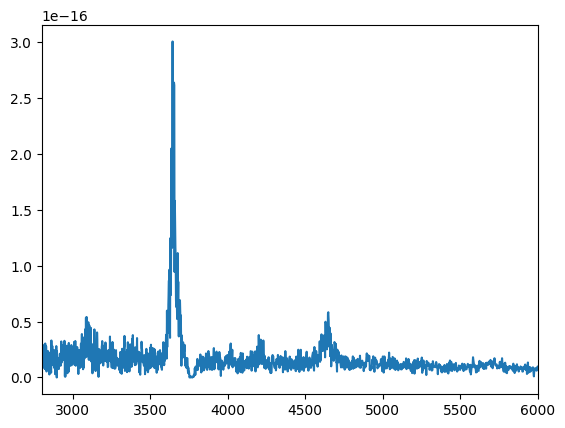

In [2]:
import matplotlib.pyplot as plt
plt.plot(wave, flux_noisy)
#plt.plot(wave,spec_with_dla)
#plt.plot(wave,spec_filtered)

plt.xlim(2800,6000)

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Standalone script to generate ONE CSST-like QSO spectrum (simqso-based),
optionally with a single DLA, then apply:
  - resolution degradation to a target R_out (assumed constant in ln λ),
  - wavelength-dependent SNR profile whose mean equals user-specified <SNR>,
  - noise model: sigma_noise(λ) = sqrt(min_sigma^2 + (|F_norm| / SNR(λ))^2).

You only need to edit the "USER CONFIG" block at the bottom:

zqso     = 2.50                  # required
zdla     = 2.10  (or None)       # optional
logNHI   = 21.2  (or None)       # optional
out      = "/path/to/output.fits"
snr_mean = 2.0                   # mean SNR over the wavelength range
seed     = 20251031              # optional RNG seed

The script:
  1. builds a fixed-R (log-lambda) grid: λ in [2000, 8000] Å,
  2. uses simqso to generate a QSO spectrum at z_qso,
  3. optionally inserts a DLA at (z_dla, logNHI),
  4. applies resolution degradation to R_out in ln λ-space,
  5. builds SNR(λ) with mean = snr_mean and SNR increasing with λ,
  6. adds noise according to your noise model,
  7. saves a FITS file with WAVELENGTH, FLUX, and FLUX_RAW (pre-noise).
"""

import os
import sys
import numpy as np
from astropy.io import fits
from astropy.cosmology import Planck13
from astropy import constants as const
from scipy.ndimage import gaussian_filter1d
from scipy.special import wofz

# ============================================================
# ===============  Inlined DLA functions (from dla.py)  ======
# ============================================================

c_cgs = const.c.to('cm/s').value  # speed of light [cm/s]


def voigt_wofz(vin, a):
    """Voigt profile via Faddeeva function (real part of wofz)."""
    return wofz(vin + 1j * a).real


def voigt_tau(wave_cm, par):
    """
    Optical depth tau at wavelengths (in cm).

    par list:
      par[0] = log10 N_HI [cm^-2]
      par[1] = z_abs
      par[2] = b [cm/s]
      par[3] = line rest wavelength [cm]  (Lyα)
      par[4] = oscillator strength f
      par[5] = gamma [s^-1]
    """
    cold = 10.0 ** par[0]
    zp1 = par[1] + 1.0
    nujk = c_cgs / par[3]
    dnu = par[2] / par[3]
    avoigt = par[5] / (4 * np.pi * dnu)
    uvoigt = ((c_cgs / (wave_cm / zp1)) - nujk) / dnu
    cne = 0.014971475 * cold * par[4]
    tau = cne * voigt_wofz(uvoigt, avoigt) / dnu
    return tau


def dla_spec(wave_ang, dlas):
    """
    Build multiplicative absorption model from a list of DLAs.
      wave_ang: observed wavelengths in Angstrom
      dlas: list of dicts with keys {'z','N','dlaid'}
            where N is log10(N_HI/cm^2)
    Returns: flux transmission (exp(-tau))
    """
    flya = 0.4164
    gamma_lya = 6.265e8
    lyacm = 1215.6700 / 1e8
    wavecm = wave_ang / 1e8

    tau = np.zeros(wave_ang.size, dtype=float)
    for dla in dlas:
        par = [
            dla['N'],          # log10 N_HI
            dla['z'],          # z_abs
            30.0 * 1e5,        # b-parameter = 30 km/s -> 3e6 cm/s
            lyacm,
            flya,
            gamma_lya
        ]
        tau += voigt_tau(wavecm, par)

    return np.exp(-tau)


def insert_dlas3(wave_ang, z_dla, logNHI):
    """
    Insert a single DLA at z_dla with logNHI.
    Returns (dlas_list, dla_model).
    """
    dlas = [dict(z=z_dla, N=logNHI, dlaid=0)]
    dla_model = dla_spec(wave_ang, dlas)
    return dlas, dla_model


# ============================================================
# ===============  simqso-based QSO generation  ==============
# ============================================================

# If your simqso is in a custom path, adapt as needed:
sys.path.append("/global/cfs/cdirs/desi/users/tingtan/CSST_DLA/simqso/desisim/")

from simqso.sqgrids import generateQlfPoints
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk
from simqso.sqmodels import BOSS_DR9_PLEpivot, get_BossDr9_model_vars




def generate_qso_spectrum(wave, z_qso,
                          qlf_seed=12345,
                          grid_seed=67890,
                          forest_seed=192837465):
    """
    Generate a single QSO spectrum at redshift z_qso on the given wavelength grid.
    Returns:
      flux (1D array), qsos (simqso object with metadata)
    """
    kcorr = sqbase.ContinuumKCorr('DECam-r', 1450, effWaveBand='SDSS-r')
    qsos = generateQlfPoints(
        BOSS_DR9_PLEpivot(cosmo=Planck13),
        (19, 22), (1.7, 3.8),
        kcorr=kcorr, zin=[z_qso],
        qlfseed=qlf_seed, gridseed=grid_seed
    )
    sedVars = get_BossDr9_model_vars(qsos, wave, 0,
                                     forestseed=forest_seed,
                                     verbose=0)
    qsos.addVars(sedVars)
    qsos.loadPhotoMap([('DECam', 'DECaLS'), ('WISE', 'AllWISE')])

    # 关键是这里：必须 saveSpectra=True 才会返回 spectra
    _, spectra = buildSpectraBulk(wave, qsos,
                                  saveSpectra=True,
                                  maxIter=3,
                                  verbose=0)

    # 防御式检查（可选）
    if spectra is None:
        raise RuntimeError("buildSpectraBulk returned None; check simqso version / arguments.")

    return spectra[0], qsos




# ============================================================
# ===============  Resolution + Noise filtering  =============
# ============================================================

def snr_profile_from_mean(wave, snr_mean):
    """
    CSST-like SNR(λ) 形状：
      - GU: 2550–4100 Å, base SNR = 1
      - GV: 4000–6400 Å, base SNR = 2
      - GI: 6200–8000 Å, base SNR = 3
    然后整体 rescale，使得 <SNR(λ)> = snr_mean。

    这样：
      - 对于 snr_mean ≈ 2 时，GU 平均 ~1，GV 平均 ~2，GI ~3；
      - 对于更高 snr_mean，三段一起抬高，但保持 GI > GV > GU。
    """

    base = np.ones_like(wave)

    # GU band: 2550–4100 Å
    GU = (wave >= 2550.0) & (wave < 4100.0)
    # GV band: 4000–6400 Å
    GV = (wave >= 4000.0) & (wave < 6400.0)
    # GI band: 6200–8000 Å
    GI = (wave >= 6200.0) & (wave <= 8000.0)

    base[GU] = 1.0
    base[GV] = 2.0
    base[GI] = 3.0

    # 避免交叠区奇怪值
    base = np.maximum(base, 1.0)

    # 归一化到给定 snr_mean
    mean_base = np.mean(base)
    snr_lambda = snr_mean * base / mean_base
    return snr_lambda



def filter_like_pipeline(wave,
                         flux,
                         R_out=241.0,
                         snr_mean=2.0,
                         min_sigma=0.02,
                         rng=np.random.default_rng(20251031)):
    """
    Apply:
      1) resolution degradation to target R_out (assumed constant in ln λ),
      2) wavelength-dependent SNR(λ) with mean = snr_mean,
      3) noise model: sigma_noise(λ) = sqrt(min_sigma^2 + (|F_norm|/SNR(λ))^2),
      4) clip at 0 (transmission-like semantics).

    Returns:
      flux_out, meta_dict
    """
    # ----- 1. Resolution degradation in ln λ -----
    loglam = np.log(wave)                       # ln λ
    dloglam = np.mean(np.diff(loglam))         # ~constant for fixed-R grid
    sigma_loglam = 1.0 / (2.355 * R_out)       # σ in ln λ for Gaussian with FWHM = 1/R_out
    sigma_pix = sigma_loglam / dloglam         # convert to pixel-space σ

    degraded = gaussian_filter1d(flux.astype(np.float64),
                                 sigma=sigma_pix,
                                 mode='reflect')

    # ----- 2. Robust normalization -----
    scale = np.percentile(np.abs(degraded), 95)
    if (not np.isfinite(scale)) or (scale <= 0):
        scale = max(np.mean(np.abs(degraded)), 1.0)
    f_norm = degraded / scale

    # ----- 3. Build SNR(λ) with <SNR>=snr_mean -----
    snr_lambda = snr_profile_from_mean(wave, snr_mean=snr_mean)

    # ----- 4. Noise model -----
    sigma_noise = np.sqrt(min_sigma**2 + (np.abs(f_norm) / snr_lambda)**2)
    noise = rng.normal(0.0, sigma_noise, size=wave.size)

    noisy = f_norm + noise
    noisy = np.clip(noisy, 0.0, None)

    flux_out = (noisy * scale).astype(np.float32)

    meta = dict(
        delta_lambda=float(np.mean(np.diff(wave))),
        lambda_eff=float(np.mean(wave)),
        sigma_pixel=float(sigma_pix),
        snr_mean=float(snr_mean),
        snr_min=float(np.min(snr_lambda)),
        snr_max=float(np.max(snr_lambda))
    )
    return flux_out, meta


# ============================================================
# ===================  Save FITS helper  =====================
# ============================================================

def save_fits(outpath,
              wave,
              flux,
              z_qso,
              z_dla,
              logNHI,
              meta,
              flux_raw=None,
              R_out=241.0,
              snr_mean=2.0,
              min_sigma=0.02,
              seed=None):
    """
    Save spectrum to FITS:
      HDU0: primary header with meta
      HDU1: WAVELENGTH [Å]
      HDU2: FLUX       (after noise)
      HDU3: FLUX_RAW   (before noise, after DLA & resolution) [optional]
    """
    pri = fits.PrimaryHDU()
    hdr = pri.header
    hdr['Z_QSO']  = (float(z_qso), 'Input QSO redshift')
    if z_dla is not None:
        hdr['Z_DLA'] = (float(z_dla), 'Inserted DLA redshift')
    else:
        hdr['Z_DLA'] = (-1.0, 'No DLA inserted')

    if logNHI is not None:
        hdr['LOGNHI'] = (float(logNHI), 'log10 N_HI [cm^-2]')
    else:
        hdr['LOGNHI'] = (-1.0, 'No DLA inserted')

    hdr['R_OUT']   = (float(R_out), 'Target resolving power after degradation')
    hdr['SNRMEAN'] = (float(snr_mean), 'Mean SNR used in noise model')
    hdr['MINSIG']  = (float(min_sigma), 'min_sigma in noise model')

    hdr['DLAM']    = (meta.get('delta_lambda', np.nan), 'mean delta_lambda [A]')
    hdr['LEFF']    = (meta.get('lambda_eff', np.nan), 'mean lambda [A]')
    hdr['SIGPIX']  = (meta.get('sigma_pixel', np.nan), 'Gaussian sigma [pix]')
    # 这里改成纯 ASCII 注释
    hdr['SNRMIN']  = (meta.get('snr_min', np.nan), 'min SNR(lambda)')
    hdr['SNRMAX']  = (meta.get('snr_max', np.nan), 'max SNR(lambda)')

    if seed is not None:
        hdr['RNGSEED'] = (int(seed), 'Random seed for noise')

    h_wave = fits.ImageHDU(data=wave.astype(np.float32), name='WAVELENGTH')
    h_flux = fits.ImageHDU(data=flux.astype(np.float32), name='FLUX')

    hdus = [pri, h_wave, h_flux]
    if flux_raw is not None:
        hdus.append(fits.ImageHDU(data=flux_raw.astype(np.float32), name='FLUX_RAW'))

    outdir = os.path.dirname(outpath)
    if outdir != '':
        os.makedirs(outdir, exist_ok=True)
    fits.HDUList(hdus).writeto(outpath, overwrite=True)
    print(f"[INFO] Saved spectrum to {outpath}")




# ============================================================
# ==========================  Main  ==========================
# ============================================================

def make_single_csst_qso(zqso,
                         zdla=None,
                         logNHI=None,
                         out="/tmp/qso.fits",
                         snr_mean=2.0,
                         seed=20251031,
                         R_out=241.0,
                         lmin=2000.0,
                         lmax=8000.0,
                         npix=2000):
    """
    High-level driver:
      zqso   : QSO redshift (required)
      zdla   : DLA redshift or None
      logNHI : DLA log10 N_HI or None
      out    : output FITS path
      snr_mean : mean SNR over λ-range
      seed   : RNG seed (int) or None
      R_out  : target resolving power after degradation
      lmin, lmax, npix: wavelength range for simqso fixed-R grid

    Returns:
      wave, flux_noisy, flux_raw
    """
    # 1) Build fixed-R (log-lambda) grid using simqso helper
    wave = sqbase.fixed_R_dispersion(lmin, lmax, npix)  # Angstrom

    # 2) Generate QSO spectrum
    spec_qso, _ = generate_qso_spectrum(wave, zqso)

    # 3) Insert DLA if requested
    if (zdla is not None) and (logNHI is not None):
        _, dla_model = insert_dlas3(wave, zdla, logNHI)
        spec_with_dla = spec_qso * dla_model
        print(f"[INFO] Inserted DLA at z={zdla:.3f}, logNHI={logNHI:.2f}")
    else:
        spec_with_dla = spec_qso
        zdla = None
        logNHI = None
        print("[INFO] No DLA inserted")

    # 4) Resolution + noise
    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()
    flux_noisy, meta = filter_like_pipeline(
        wave,
        spec_with_dla,
        R_out=R_out,
        snr_mean=snr_mean,
        min_sigma=0.02,
        rng=rng
    )

    # 5) Save FITS
    save_fits(
        outpath=out,
        wave=wave,
        flux=flux_noisy,
        z_qso=zqso,
        z_dla=zdla,
        logNHI=logNHI,
        meta=meta,
        flux_raw=spec_with_dla.astype(np.float32),
        R_out=R_out,
        snr_mean=snr_mean,
        min_sigma=0.02,
        seed=seed
    )

    return wave, flux_noisy, spec_with_dla


if __name__ == "__main__":
    # ====================== USER CONFIG ======================
    zqso     = 2.0
    zdla     = 2.10        # or None
    logNHI   = 21.2        # or None
    out      = "/global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/data/qso_z2p50_dla_z2p10_N21p20.fits"
    snr_mean = 3.0         # mean SNR over the whole spectrum
    seed     = 20251031    # or None

    # Optional: you can also tweak R_out / λ-range / npix if needed
    R_out = 241.0
    L_MIN, L_MAX, NPIX = 2000.0, 8000.0, 2000

    wave, flux_noisy, flux_raw = make_single_csst_qso(
        zqso=zqso,
        zdla=zdla,
        logNHI=logNHI,
        out=out,
        snr_mean=snr_mean,
        seed=seed,
        R_out=R_out,
        lmin=L_MIN,
        lmax=L_MAX,
        npix=NPIX
    )



[INFO] Inserted DLA at z=2.100, logNHI=21.20
[INFO] Saved spectrum to /global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/data/qso_z2p50_dla_z2p10_N21p20.fits


(2800.0, 6000.0)

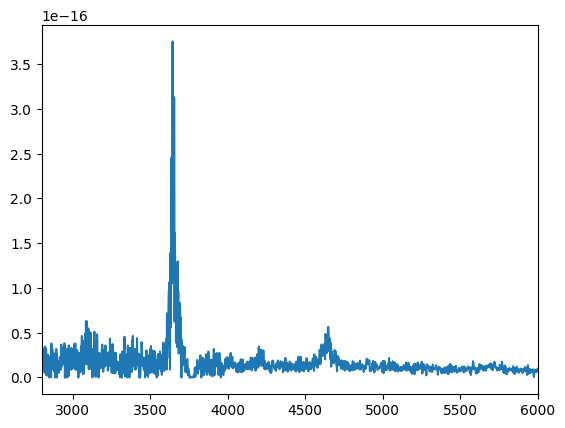

In [4]:
import matplotlib.pyplot as plt
plt.plot(wave, flux_noisy)
#plt.plot(wave,spec_with_dla)
#plt.plot(wave,spec_filtered)

plt.xlim(2800,6000)

# Generate 100 spectra, with 40 high snr, 30 mid, 30 low. Different redshift from 1-3.5

In [5]:
if __name__ == "__main__":
    # ====================== BATCH CONFIG ======================
    R_out = 241.0
    L_MIN, L_MAX, NPIX = 2000.0, 8000.0, 2000  # simqso 在 2000–8000 上跑
    base_outdir = "/global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/mock_set1"

    # 三档 SNR：可以按需要微调
    SNR_HIGH = 4.0   # 高 SNR 档：整体比较好
    SNR_MID  = 3.0   # 中 SNR 档
    SNR_LOW  = 2.0   # 低 SNR 档（此时大约 GU~1, GV~2）

    N_HIGH, N_MID, N_LOW = 40, 30, 30
    N_TOTAL = N_HIGH + N_MID + N_LOW

    # 红移在 [1.0, 3.5] 均匀抽
    master_seed = 20251031
    rng = np.random.default_rng(master_seed)
    zqsos = rng.uniform(1.0, 3.5, size=N_TOTAL)

    # SNR 档位标签
    labels = (["high"] * N_HIGH) + (["mid"] * N_MID) + (["low"] * N_LOW)
    label_to_snr = {
        "high": SNR_HIGH,
        "mid":  SNR_MID,
        "low":  SNR_LOW,
    }

    os.makedirs(base_outdir, exist_ok=True)

    for i, (zqso, lab) in enumerate(zip(zqsos, labels)):
        snr_mean = label_to_snr[lab]
        seed = master_seed + i

        # 这里先不加 DLA：zdla=None, logNHI=None
        zdla = None
        logNHI = None

        out = os.path.join(
            base_outdir,
            f"csst_qso_{i:03d}_z{zqso:.2f}_{lab}.fits"
        )

        print(f"[{i+1:03d}/{N_TOTAL}] z={zqso:.3f}, SNR={lab} "
              f"(snr_mean={snr_mean}), out={out}")

        wave, flux_noisy, flux_raw = make_single_csst_qso(
            zqso=zqso,
            zdla=zdla,
            logNHI=logNHI,
            out=out,
            snr_mean=snr_mean,
            seed=seed,
            R_out=R_out,
            lmin=L_MIN,
            lmax=L_MAX,
            npix=NPIX
        )


[001/100] z=2.668, SNR=high (snr_mean=4.0), out=/global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/mock_set1/csst_qso_000_z2.67_high.fits
[INFO] No DLA inserted
[INFO] Saved spectrum to /global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/mock_set1/csst_qso_000_z2.67_high.fits
[002/100] z=2.974, SNR=high (snr_mean=4.0), out=/global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/mock_set1/csst_qso_001_z2.97_high.fits
[INFO] No DLA inserted
[INFO] Saved spectrum to /global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/mock_set1/csst_qso_001_z2.97_high.fits
[003/100] z=1.325, SNR=high (snr_mean=4.0), out=/global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/mock_set1/csst_qso_002_z1.33_high.fits
[INFO] No DLA inserted
[INFO] Saved spectrum to /global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/mock_set1/csst_qso_002_z1.33_high.fits
[004/100] z=2.708, SNR=high (snr_mean=4.0), out=/global/cfs/cdirs/desi/users/tingtan/CSST_fore

In [6]:
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.table import Table

# ======== 路径设置：改这里就行 ========
indir = "/global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/mock_set1"
outbase = "/global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/mock_set1/truth_catalog"

# 找到所有光谱文件
files = sorted(glob.glob(os.path.join(indir, "csst_qso_*.fits")))
print(f"Found {len(files)} files")

rows = []

for fname in files:
    with fits.open(fname) as hdul:
        hdr = hdul[0].header

        z_qso   = hdr.get("Z_QSO",   np.nan)
        z_dla   = hdr.get("Z_DLA",   np.nan)
        logNHI  = hdr.get("LOGNHI",  np.nan)
        snrmean = hdr.get("SNRMEAN", np.nan)
        rngseed = hdr.get("RNGSEED", -1)

    # 从文件名解析 index / z / SNR 档位
    # 例如: csst_qso_000_z2.67_high.fits
    base = os.path.basename(fname)
    name, _ = os.path.splitext(base)

    # 粗暴一点：按下划线拆
    parts = name.split("_")
    # parts = ["csst", "qso", "000", "z2.67", "high"]
    try:
        idx = int(parts[2])
    except Exception:
        idx = -1

    # label: high/mid/low 在最后一段
    label = parts[-1]

    # 也可以从 "z2.67" 再 parse 一下，但 header 里已经有 Z_QSO 了，这里可选
    rows.append(dict(
        FILENAME=base,
        INDEX=idx,
        LABEL=label,
        Z_QSO=z_qso,
        Z_DLA=z_dla if z_dla != -1 else np.nan,
        LOGNHI=logNHI if logNHI != -1 else np.nan,
        SNRMEAN=snrmean,
        RNGSEED=rngseed
    ))

# 转成 astropy Table
tab = Table(rows)

print(tab[:5])
print(f"Total rows: {len(tab)}")

# 保存为 FITS 和 CSV
fits_path = outbase + ".fits"
csv_path  = outbase + ".csv"

tab.write(fits_path, overwrite=True)
tab.write(csv_path, overwrite=True)

print(f"[INFO] Wrote truth catalog to:\n  {fits_path}\n  {csv_path}")


Found 100 files
          FILENAME           INDEX LABEL ... LOGNHI SNRMEAN RNGSEED 
---------------------------- ----- ----- ... ------ ------- --------
csst_qso_000_z2.67_high.fits     0  high ...    nan     4.0 20251031
csst_qso_001_z2.97_high.fits     1  high ...    nan     4.0 20251032
csst_qso_002_z1.33_high.fits     2  high ...    nan     4.0 20251033
csst_qso_003_z2.71_high.fits     3  high ...    nan     4.0 20251034
csst_qso_004_z2.75_high.fits     4  high ...    nan     4.0 20251035
Total rows: 100
[INFO] Wrote truth catalog to:
  /global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/mock_set1/truth_catalog.fits
  /global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/mock_set1/truth_catalog.csv


In [ ]:
tab

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Generate ONE CSST-like QSO spectrum at user-specified z_qso, insert a DLA at
user-specified z_dla (with logNHI), then apply spectra filtering consistent with
the user's pipeline:
  - resolution degradation using R and lambda_cut,
  - add noise with SNR=1 for lambda < lambda_cut using
      sigma_noise = sqrt(min_sigma^2 + (F/snr)^2).

This version is *standalone*: it inlines the needed DLA functions from your dla.py
(insert_dlas3, dla_spec, voigt_tau, voigt_wofz).

Usage example:
  python make_single_csst_qso_with_dla_standalone.py \
    --zqso 2.5 --zdla 2.1 --logNHI 21.2 \
    --out /global/cfs/cdirs/desi/users/tingtan/CSST_DLA/mockdata_noise/qso_z2p5_dla_z2p1_N21p2.fits
"""

import os
import sys
import argparse
import numpy as np
from astropy.io import fits
from astropy.cosmology import Planck13
from astropy import constants as const
from scipy.ndimage import gaussian_filter1d
from scipy.special import wofz

# ============================================================
# ===============  Inlined DLA functions (from dla.py)  ======
# ============================================================

c_cgs = const.c.to('cm/s').value  # speed of light [cm/s]

def voigt_wofz(vin, a):
    """Voigt profile via Faddeeva function (real part of wofz)."""
    return wofz(vin + 1j * a).real

def voigt_tau(wave_cm, par):
    """
    Optical depth tau at wavelengths (in cm).

    par list:
      par[0] = log10 N_HI [cm^-2]
      par[1] = z_abs
      par[2] = b [cm/s]
      par[3] = line rest wavelength [cm]  (Lyα)
      par[4] = oscillator strength f
      par[5] = gamma [s^-1]
    """
    cold = 10.0 ** par[0]
    zp1 = par[1] + 1.0
    nujk = c_cgs / par[3]
    dnu = par[2] / par[3]
    avoigt = par[5] / (4 * np.pi * dnu)
    uvoigt = ((c_cgs / (wave_cm / zp1)) - nujk) / dnu
    cne = 0.014971475 * cold * par[4]
    tau = cne * voigt_wofz(uvoigt, avoigt) / dnu
    return tau

def dla_spec(wave_ang, dlas):
    """
    Build multiplicative absorption model from a list of DLAs.
      wave_ang: observed wavelengths in Angstrom
      dlas: list of dicts with keys {'z','N','dlaid'}
            where N is log10(N_HI/cm^2)
    Returns: flux transmission (exp(-tau))
    """
    flya = 0.4164
    gamma_lya = 6.265e8
    lyacm = 1215.6700 / 1e8
    wavecm = wave_ang / 1e8

    tau = np.zeros(wave_ang.size, dtype=float)
    for dla in dlas:
        par = [dla['N'],
               dla['z'],
               30*1e5,    # b-parameter = 30 km/s -> 3e6 cm/s
               lyacm,
               flya,
               gamma_lya]
        tau += voigt_tau(wavecm, par)

    return np.exp(-tau)

def insert_dlas3(wave_ang, z_dla, logNHI):
    """
    Exactly your helper: insert a single DLA at z_dla with logNHI.
    Returns (dlas_list, dla_model).
    """
    dlas = [dict(z=z_dla, N=logNHI, dlaid=0)]
    dla_model = dla_spec(wave_ang, dlas)
    return dlas, dla_model

# ============================================================
# ===============  simqso-based QSO generation  ==============
# ============================================================

# If your simqso is in a custom path, keep these (or adapt if needed).
sys.path.append("/global/cfs/cdirs/desi/users/tingtan/CSST_DLA/simqso/desisim/")
from simqso.sqgrids import generateQlfPoints
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk
from simqso.sqmodels import BOSS_DR9_PLEpivot, get_BossDr9_model_vars

# ============================================================
# ===============  CSST wave grid (nm -> Å) ==================
# ============================================================

BANDS = {
    "GU": {"start": 255.0, "end": 410.0, "dl": 1.16},
    "GV": {"start": 400.0, "end": 640.0, "dl": 2.24},
    "GI": {"start": 620.0, "end": 1000.0, "dl": 3.91},
}

def merged_wave_angstrom():
    waves = []
    for k in sorted(BANDS.keys(), key=lambda x: BANDS[x]["start"]):
        b = BANDS[k]
        w = np.arange(b["start"], b["end"] + b["dl"]/2.0, b["dl"])  # nm
        waves.append(w)
    wave_nm = np.concatenate(waves)
    return wave_nm * 10.0  # to Å

def generate_qso_spectrum(wave, z_qso, qlf_seed=12345, grid_seed=67890, forest_seed=192837465):
    '''
    kcorr = sqbase.ContinuumKCorr('DECam-r', 1450, effWaveBand='SDSS-r')
    qsos = generateQlfPoints(
        BOSS_DR9_PLEpivot(cosmo=Planck13),
        (19, 22), (1.7, 3.8),
        kcorr=kcorr, zin=[z_qso],
        qlfseed=qlf_seed, gridseed=grid_seed
    )
    sed_vars = get_BossDr9_model_vars(qsos, wave, 0, forestseed=forest_seed, verbose=0)
    qsos.addVars(sed_vars)
    qsos.loadPhotoMap([('DECam', 'DECaLS'), ('WISE', 'AllWISE')])
    _, spectra = buildSpectraBulk(wave, qsos, saveSpectra=False, maxIter=3, verbose=0)
    return spectra[0]  # array of flux
    '''
    kcorr = sqbase.ContinuumKCorr('DECam-r', 1450, effWaveBand='SDSS-r')
    qsos = generateQlfPoints(
        BOSS_DR9_PLEpivot(cosmo=Planck13),
        (19, 22), (1.7, 3.8),
        kcorr=kcorr, zin=[z_qso],
        qlfseed=12345, gridseed=67890
    )
    sedVars = get_BossDr9_model_vars(qsos, wave, 0, forestseed=192837465, verbose=0)
    qsos.addVars(sedVars)
    qsos.loadPhotoMap([('DECam', 'DECaLS'), ('WISE', 'AllWISE')])
    _, spectra = buildSpectraBulk(wave, qsos, saveSpectra=True, maxIter=3, verbose=0)
    return spectra[0], qsos

# ============================================================
# ===============  Filtering (degrade + noise) ===============
# ============================================================
def measure_fwhm_at(wave, sigma_pix, lam0, window=30):
    d = np.zeros_like(wave); i0 = np.argmin(np.abs(wave - lam0)); d[i0] = 1.0
    k = gaussian_filter1d(d, sigma=sigma_pix, mode='reflect')
    j0 = i0; j1 = min(len(wave)-1, i0+window); j2 = max(0, i0-window)
    kseg, wseg = k[j2:j1+1], wave[j2:j1+1]
    half = kseg.max()/2
    L = wseg[np.where(kseg>=half)[0][0]]
    R = wseg[np.where(kseg>=half)[0][-1]]
    return R - L

def filter_like_pipeline(wave, flux,
                         R=241.0, lambda_cut=4200.0, min_sigma=0.02, snr=1.0,
                         rng=np.random.default_rng(20251031)):
    """
    Your pipeline's numeric logic:
      delta_lambda = mean(diff(wave))
      lambda_eff   = mean(wave[wave<lambda_cut]) else mean(wave)
      sigma_pixel  = (lambda_eff / (2.355 * R)) / delta_lambda
      degraded     = gaussian_filter1d(flux, sigma_pixel)
      For wave<lambda_cut:
        sigma_noise = sqrt(min_sigma^2 + (F/snr)^2)
        noisy = degraded + Normal(0, sigma_noise)
      Clip to non-negative (transmission-like semantics).
    Noise is added in a robustly normalized domain, then rescaled back.
    """
    dlam = np.mean(np.diff(wave))
    #lam_eff = np.mean(wave[wave < lambda_cut]) if np.any(wave < lambda_cut) else np.mean(wave)
    #sigma_pix = (lam_eff / (2.355 * R)) / dlam
    R_GRID = 3000.0
    lam_eff = 3600.0        # 或 np.sqrt(2500*4200) ≈ 3240. 选你最关心的点
    sigma_pix = (8.0 * R_GRID) / (2.355 * lam_eff)
    #print(sigma_pix)
    print(dlam,sigma_pix,measure_fwhm_at(wave, sigma_pix, lam_eff))
    
    degraded = gaussian_filter1d(flux.astype(np.float64), sigma=sigma_pix)

    # robust scale for normalization
    scale = np.percentile(np.abs(degraded), 95)
    if not np.isfinite(scale) or scale <= 0:
        scale = max(np.mean(np.abs(degraded)), 1.0)
    f_norm = degraded / scale

    #mask = wave < lambda_cut
    mask = wave < 10000
    noisy = f_norm.copy()
    if np.any(mask):
        sigma_noise = np.sqrt(min_sigma**2 + (np.abs(f_norm[mask]) / snr)**2)
        noise = rng.normal(0.0, sigma_noise, size=mask.sum())
        noisy[mask] = f_norm[mask] + noise
        noisy[mask] = np.clip(noisy[mask], 0.0, None)

    flux_out = (noisy * scale).astype(np.float32)
    meta = dict(delta_lambda=float(dlam), lambda_eff=float(lam_eff), sigma_pixel=float(sigma_pix))
    return flux_out, meta

# ============================================================
# ===================  Save FITS helper  =====================
# ============================================================

def save_fits(outpath, wave, flux, z_qso, z_dla, logNHI, meta, flux_raw=None,
              R=241.0, lambda_cut=4200.0, snr=1.0, min_sigma=0.02):
    pri = fits.PrimaryHDU()
    hdr = pri.header
    hdr['Z_QSO']  = (float(z_qso), 'Input QSO redshift')
    hdr['Z_DLA']  = (float(z_dla), 'Inserted DLA redshift')
    hdr['LOGNHI'] = (float(logNHI), 'log10 N_HI [cm^-2]')
    hdr['R']      = (float(R), 'Resolving power used for degradation')
    hdr['LCUT']   = (float(lambda_cut), 'Lambda cutoff for noise [A]')
    hdr['SNR']    = (float(snr), 'Target SNR in noise model')
    hdr['MINSIG'] = (float(min_sigma), 'min_sigma in noise model')
    hdr['DLAM']   = (meta.get('delta_lambda', np.nan), 'mean delta_lambda [A]')
    hdr['LEFF']   = (meta.get('lambda_eff', np.nan), 'lambda_eff [A]')
    hdr['SIGPIX'] = (meta.get('sigma_pixel', np.nan), 'Gaussian sigma [pix]')

    h_wave = fits.ImageHDU(data=wave.astype(np.float32), name='WAVELENGTH')
    h_flux = fits.ImageHDU(data=flux.astype(np.float32), name='FLUX')

    hdus = [pri, h_wave, h_flux]
    if flux_raw is not None:
        hdus.append(fits.ImageHDU(data=flux_raw.astype(np.float32), name='FLUX_RAW'))

    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    fits.HDUList(hdus).writeto(outpath, overwrite=True)

# ============================================================
# =========================  Main  ===========================
# ============================================================


In [2]:
zqso=2.50
zdla=2.10
logNHI=21.2
out="/global/cfs/cdirs/desi/users/tingtan/CSST_forecast/DLA_forecast/data/qso_z2p50_dla_z2p10_N21p20.fits",
R=241.0
lambda_cut=4200.0
snr=2
min_sigma=0.02
seed=20251031

#wave = merged_wave_angstrom()
wave = sqbase.fixed_R_dispersion(2000, 8000, 2000)
#L_MIN, L_MAX, DLAM = 2000.0, 8000.0, 2.0
#wave = np.arange(L_MIN, L_MAX + DLAM/2, DLAM)

spec,qsos = generate_qso_spectrum(wave, zqso)
# Insert DLA (inline version of your dla.insert_dlas3)
_, dla_model = insert_dlas3(wave, zdla, logNHI)
spec_with_dla = spec * dla_model

rng = np.random.default_rng(seed)
spec_filtered, meta = filter_like_pipeline(
    wave, spec_with_dla, R=R, lambda_cut=lambda_cut,
    min_sigma=min_sigma, snr=snr, rng=rng
)




#save_fits(out, wave, spec_filtered, zqso, zdla, logNHI, meta,          flux_raw=spec_with_dla.astype(np.float32),          R=R, lambda_cut=lambda_cut, snr=snr, min_sigma=min_sigma)

2.1643149225372245 2.8308563340410475 10.802308315687242


(2800.0, 6000.0)

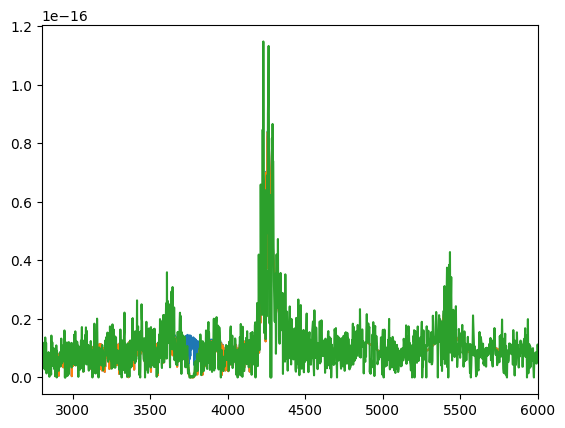

In [3]:
import matplotlib.pyplot as plt
plt.plot(wave,spec)
plt.plot(wave,spec_with_dla)
plt.plot(wave,spec_filtered)

plt.xlim(2800,6000)

(2800.0, 6000.0)

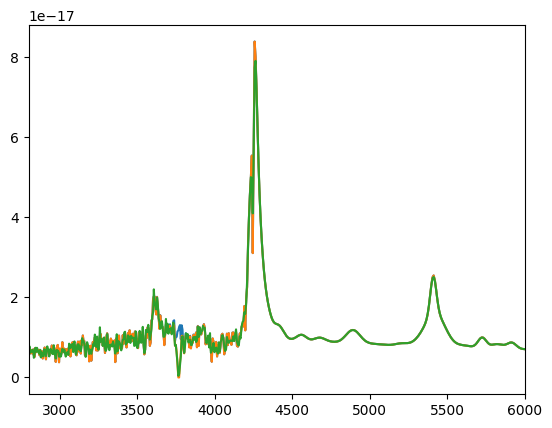

In [5]:
logNHI=20.3
snr=10
min_sigma=0.02
_, dla_model = insert_dlas3(wave, zdla, logNHI)
spec_with_dla = spec * dla_model
rng = np.random.default_rng(seed)
spec_filtered, meta = filter_like_pipeline(
    wave, spec_with_dla, R=R, lambda_cut=lambda_cut,
    min_sigma=min_sigma, snr=snr, rng=rng
)
import matplotlib.pyplot as plt
plt.plot(wave,spec)
plt.plot(wave,spec_with_dla)
plt.plot(wave,spec_filtered)

plt.xlim(2800,6000)


(2800.0, 6000.0)

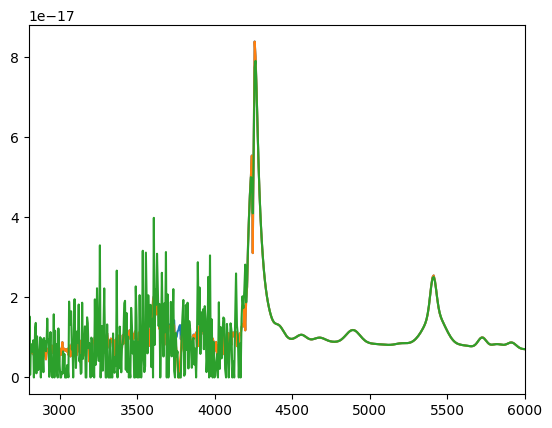

In [6]:
logNHI=20.3
snr=1
min_sigma=0.02
_, dla_model = insert_dlas3(wave, zdla, logNHI)
spec_with_dla = spec * dla_model
rng = np.random.default_rng(seed)
spec_filtered, meta = filter_like_pipeline(
    wave, spec_with_dla, R=R, lambda_cut=lambda_cut,
    min_sigma=min_sigma, snr=snr, rng=rng
)
import matplotlib.pyplot as plt
plt.plot(wave,spec)
plt.plot(wave,spec_with_dla)
plt.plot(wave,spec_filtered)

plt.xlim(2800,6000)


(2800.0, 6000.0)

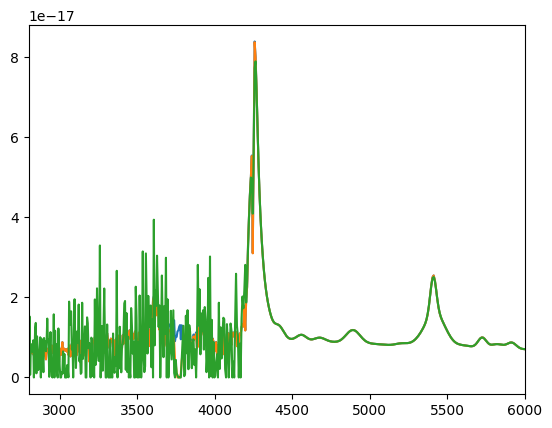

In [7]:
logNHI=21
snr=1
min_sigma=0.02
_, dla_model = insert_dlas3(wave, zdla, logNHI)
spec_with_dla = spec * dla_model
rng = np.random.default_rng(seed)
spec_filtered, meta = filter_like_pipeline(
    wave, spec_with_dla, R=R, lambda_cut=lambda_cut,
    min_sigma=min_sigma, snr=snr, rng=rng
)
import matplotlib.pyplot as plt
plt.plot(wave,spec)
plt.plot(wave,spec_with_dla)
plt.plot(wave,spec_filtered)

plt.xlim(2800,6000)


(2800.0, 6000.0)

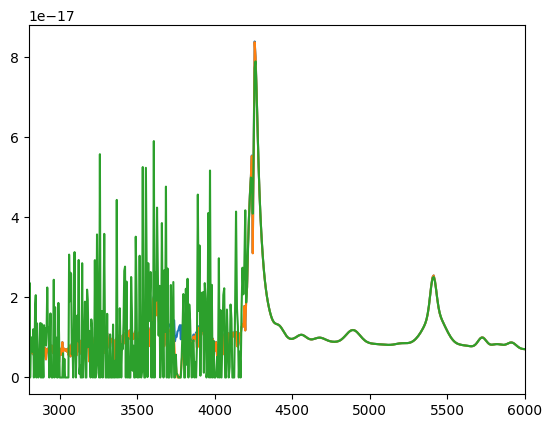

In [8]:
logNHI=21
snr=0.5
min_sigma=0.02
_, dla_model = insert_dlas3(wave, zdla, logNHI)
spec_with_dla = spec * dla_model
rng = np.random.default_rng(seed)
spec_filtered, meta = filter_like_pipeline(
    wave, spec_with_dla, R=R, lambda_cut=lambda_cut,
    min_sigma=min_sigma, snr=snr, rng=rng
)
import matplotlib.pyplot as plt
plt.plot(wave,spec)
plt.plot(wave,spec_with_dla)
plt.plot(wave,spec_filtered)

plt.xlim(2800,6000)


In [1]:
logNHI=21
snr=1
min_sigma=0.02
_, dla_model = insert_dlas3(wave, zdla, logNHI)
spec_with_dla = spec * dla_model
rng = np.random.default_rng(seed)
spec_filtered, meta = filter_like_pipeline(
    wave, spec_with_dla, R=R, lambda_cut=lambda_cut,
    min_sigma=min_sigma, snr=snr, rng=rng
)
import matplotlib.pyplot as plt
plt.plot(wave,spec)
plt.plot(wave,spec_with_dla)
plt.plot(wave,spec_filtered)

plt.xlim(3600,3700)


NameError: name 'insert_dlas3' is not defined